## Imports

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold


## Paths

In [3]:
DATA_DIR = r"D:\histopathologic-cancer-detection-"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

labels_df = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))
labels_df.head()


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## Data Understanding

In [4]:
labels_df['label'].value_counts()


0    130908
1     89117
Name: label, dtype: int64

## Bar Chart – Class Distribution

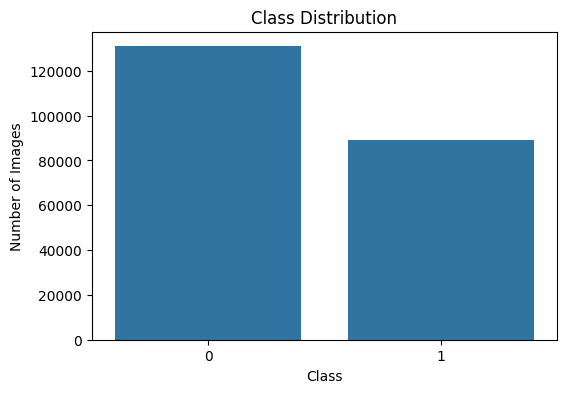

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=labels_df)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


## Sample Images per Class

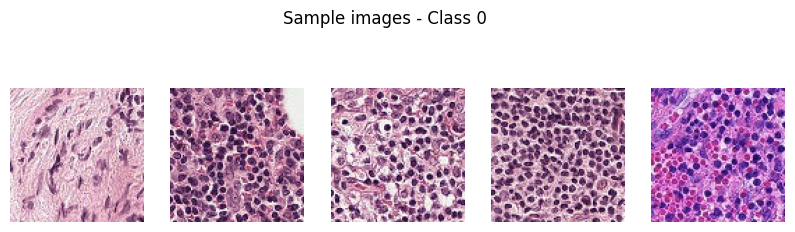

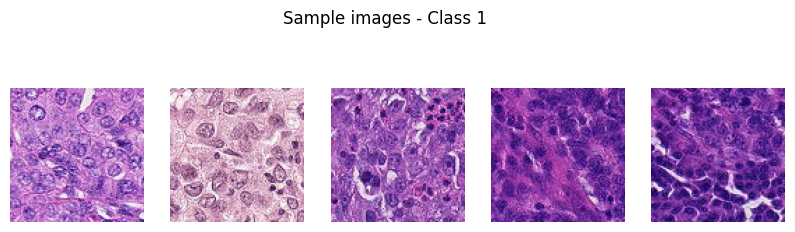

In [6]:
def show_samples(label, n=5):
    samples = labels_df[labels_df['label']==label].sample(n)
    plt.figure(figsize=(10,3))
    for i, (_, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(TRAIN_DIR, row['id'] + ".tif")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Sample images - Class {label}")
    plt.show()

show_samples(0)
show_samples(1)


In [7]:
def is_corrupted(path):
    try:
        img = cv2.imread(path)
        if img is None:
            return True
        return False
    except:
        return True


In [8]:
corrupted = []

for _, row in tqdm(labels_df.iterrows(), total=len(labels_df)):
    path = os.path.join(TRAIN_DIR, row['id'] + ".tif")
    if is_corrupted(path):
        corrupted.append(row['id'])

len(corrupted)


100%|██████████| 220025/220025 [27:03<00:00, 135.50it/s]


0

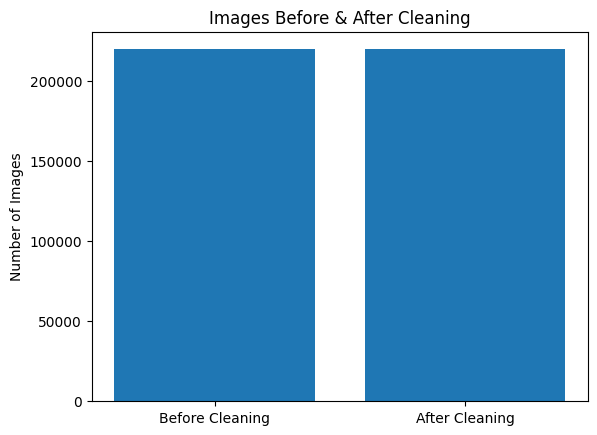

In [9]:
before = len(labels_df)
labels_df = labels_df[~labels_df['id'].isin(corrupted)]
after = len(labels_df)

plt.bar(["Before Cleaning", "After Cleaning"], [before, after])
plt.title("Images Before & After Cleaning")
plt.ylabel("Number of Images")
plt.show()


## Noise & Outliers Detection

Pixel Intensity Distribution

In [10]:
def pixel_intensity(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray.flatten()


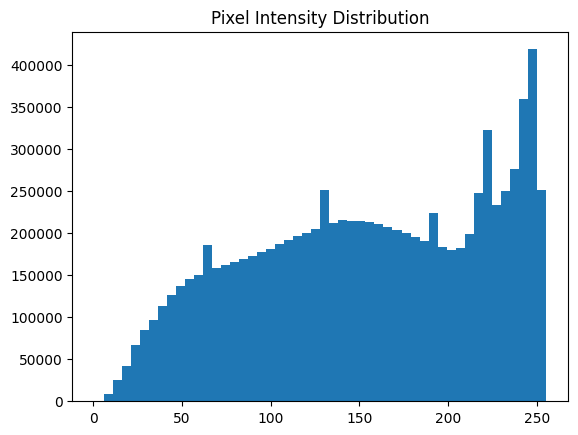

In [11]:
pixels = []

sample_df = labels_df.sample(1000)

for _, row in sample_df.iterrows():
    img = cv2.imread(os.path.join(TRAIN_DIR, row['id'] + ".tif"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pixels.extend(pixel_intensity(img))

plt.hist(pixels, bins=50)
plt.title("Pixel Intensity Distribution")
plt.show()


Blur Detection (Outliers)

In [12]:
def blur_score(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()


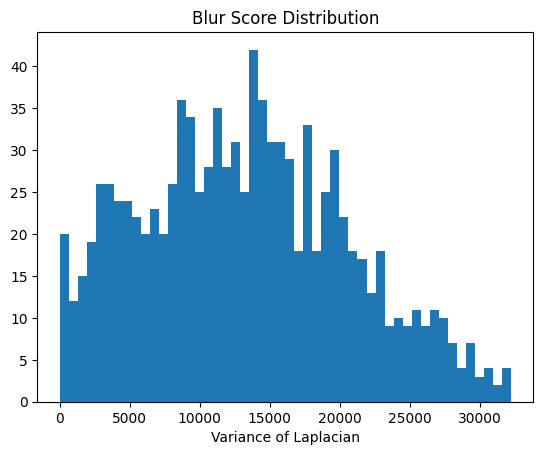

In [15]:
blur_scores = []

for _, row in sample_df.iterrows():
    img = cv2.imread(os.path.join(TRAIN_DIR, row['id'] + ".tif"))
    blur_scores.append(blur_score(img))

plt.hist(blur_scores, bins=50)
plt.title("Blur Score Distribution")
plt.xlabel("Variance of Laplacian")
plt.show()


## Data Transformation

Normalization

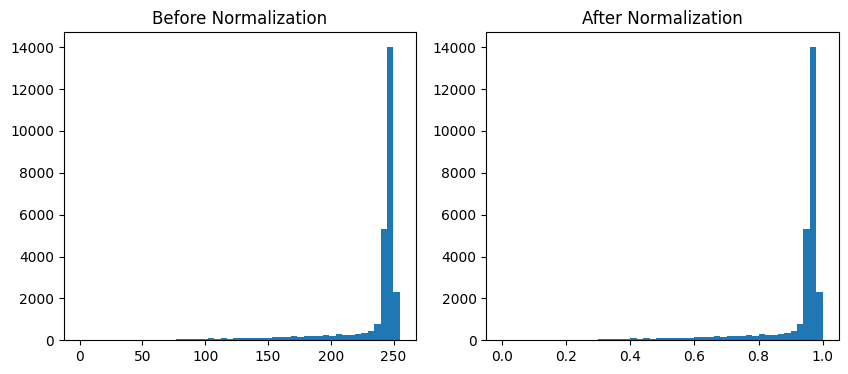

In [16]:
img = cv2.imread(os.path.join(TRAIN_DIR, labels_df.iloc[0]['id'] + ".tif"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(img.flatten(), bins=50)
plt.title("Before Normalization")

img_norm = img / 255.0
plt.subplot(1,2,2)
plt.hist(img_norm.flatten(), bins=50)
plt.title("After Normalization")
plt.show()


Resizing

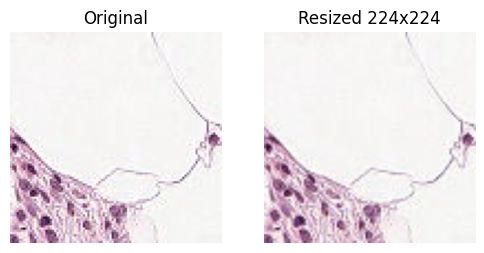

In [17]:
resized = cv2.resize(img, (224,224))

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(resized)
plt.title("Resized 224x224")
plt.axis('off')
plt.show()


## Feature Extraction – Hand Crafted

Color Histogram Features

In [18]:
def color_hist(img):
    hist = []
    for i in range(3):
        h = cv2.calcHist([img],[i],None,[32],[0,256])
        hist.extend(h.flatten())
    return np.array(hist)


In [19]:
features = []
labels = []

for _, row in labels_df.sample(2000).iterrows():
    img = cv2.imread(os.path.join(TRAIN_DIR, row['id'] + ".tif"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    features.append(color_hist(img))
    labels.append(row['label'])

X = np.array(features)
y = np.array(labels)


Feature Distribution

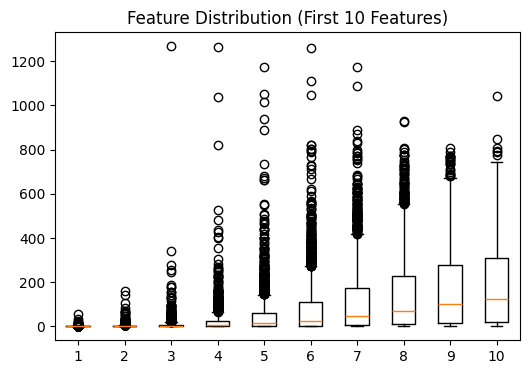

In [7]:
plt.figure(figsize=(6,4))
plt.boxplot(X[:,:10])
plt.title("Feature Distribution (First 10 Features)")
plt.show()


## PCA – Dimensionality Reduction

In [20]:
X_scaled = StandardScaler().fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)


Explained Variance

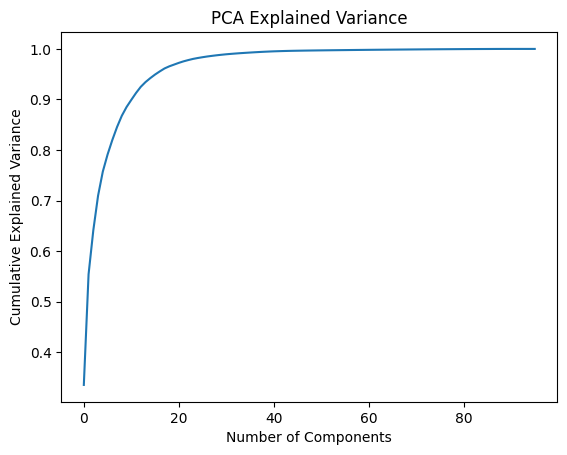

In [21]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()


PCA Scatter (2D)

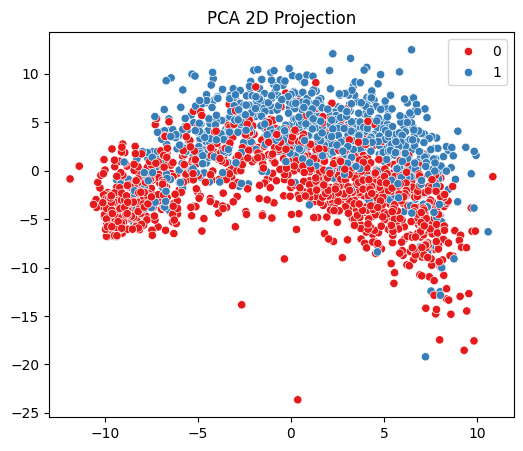

In [22]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette="Set1")
plt.title("PCA 2D Projection")
plt.show()


## Feature Selection

In [23]:
selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(X)

X.shape, X_selected.shape


((2000, 96), (2000, 96))

Feature Reduction

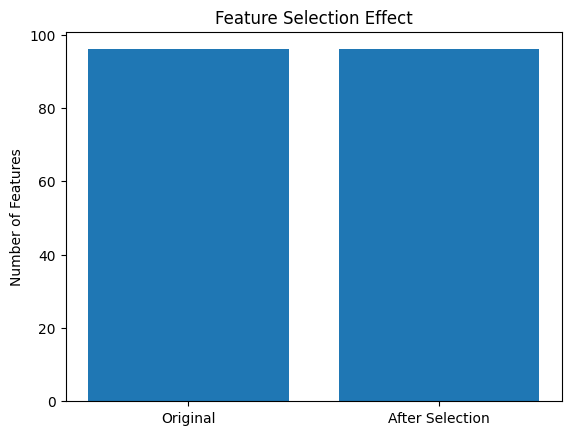

In [24]:
plt.bar(["Original", "After Selection"], [X.shape[1], X_selected.shape[1]])
plt.title("Feature Selection Effect")
plt.ylabel("Number of Features")
plt.show()


## Class Imbalance Analysis

In [25]:
class_counts = labels_df['label'].value_counts().sort_index()
class_counts


0    130908
1     89117
Name: label, dtype: int64

Bar Chart – Class Distribution

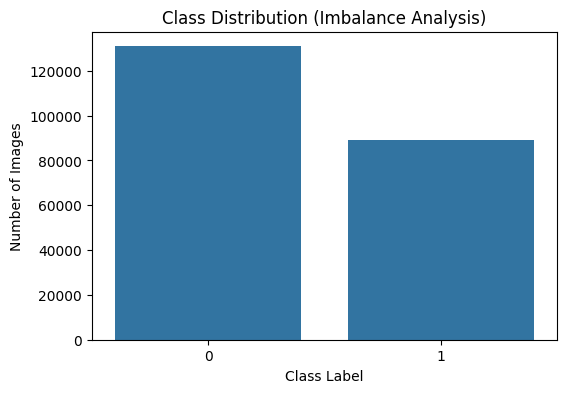

In [26]:
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution (Imbalance Analysis)")
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.show()


Pie Chart

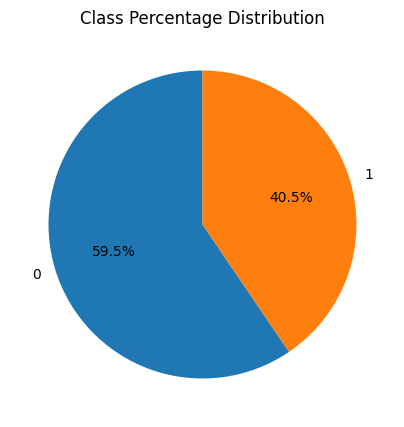

In [27]:
plt.figure(figsize=(5,5))
plt.pie(class_counts.values,
        labels=class_counts.index,
        autopct='%1.1f%%',
        startangle=90)
plt.title("Class Percentage Distribution")
plt.show()


## Sampling Strategy

In [28]:
SAMPLE_SIZE = 10000

sampled_df = (
    labels_df
    .groupby('label', group_keys=False)
    .apply(lambda x: x.sample(int(len(x) / len(labels_df) * SAMPLE_SIZE)))
)

sampled_df['label'].value_counts()


0    5949
1    4050
Name: label, dtype: int64

Distribution before and after Sampling

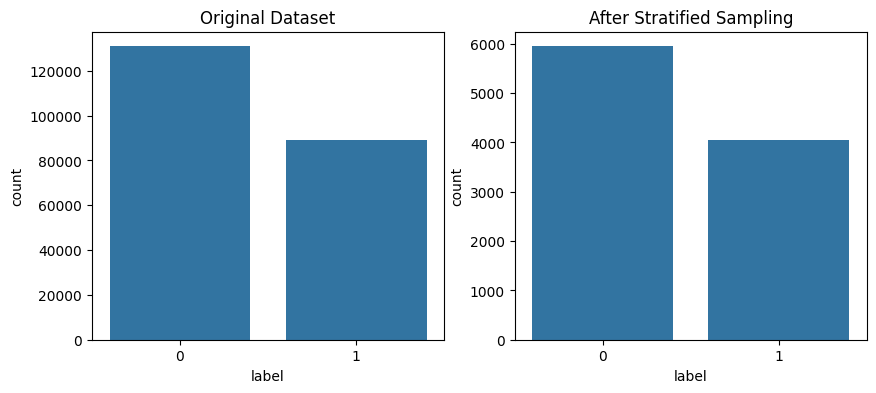

In [29]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

sns.countplot(x='label', data=labels_df, ax=axes[0])
axes[0].set_title("Original Dataset")

sns.countplot(x='label', data=sampled_df, ax=axes[1])
axes[1].set_title("After Stratified Sampling")

plt.show()


## Train / Validation Split

In [30]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    sampled_df,
    test_size=0.2,
    stratify=sampled_df['label'],
    random_state=42
)

train_df['label'].value_counts(), val_df['label'].value_counts()


(0    4759
 1    3240
 Name: label, dtype: int64,
 0    1190
 1     810
 Name: label, dtype: int64)

Class Distribution – Train vs Validation

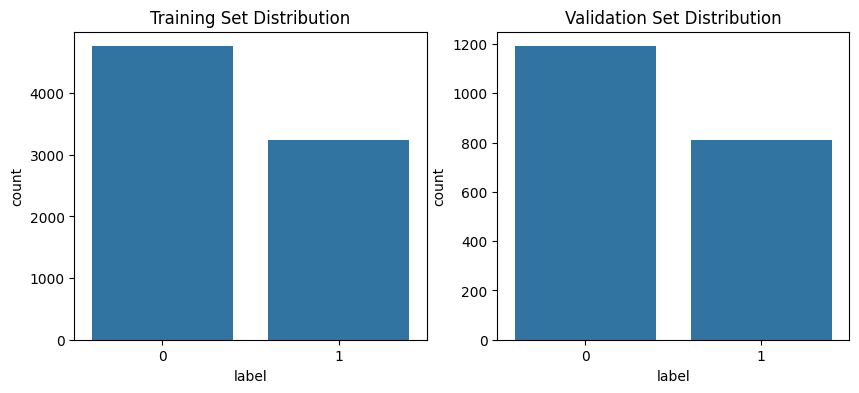

In [31]:
fig, axes = plt.subplots(1,2, figsize=(10,4))

sns.countplot(x='label', data=train_df, ax=axes[0])
axes[0].set_title("Training Set Distribution")

sns.countplot(x='label', data=val_df, ax=axes[1])
axes[1].set_title("Validation Set Distribution")

plt.show()


## Feature-wise Class Comparison

Bar chart: mean feature value (class 0 vs class 1)

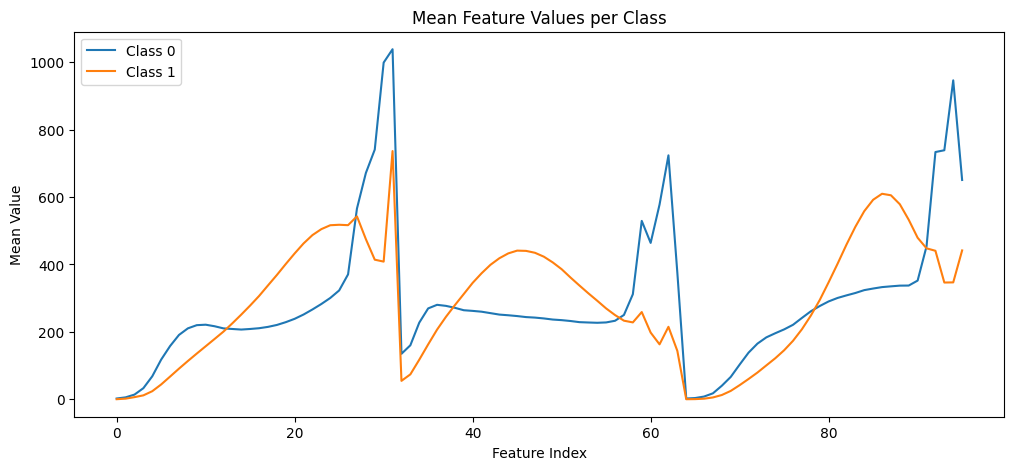

In [33]:
X_df = pd.DataFrame(X)
X_df['label'] = y

mean_class0 = X_df[X_df['label'] == 0].mean()
mean_class1 = X_df[X_df['label'] == 1].mean()

plt.figure(figsize=(12,5))
plt.plot(mean_class0[:-1], label='Class 0')
plt.plot(mean_class1[:-1], label='Class 1')
plt.title("Mean Feature Values per Class")
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.legend()
plt.show()

Boxplot – Feature Distribution per Class

d:\Data\python_10\tensorflow-env\lib\site-packages\pandas\plotting\_core.py:1746: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


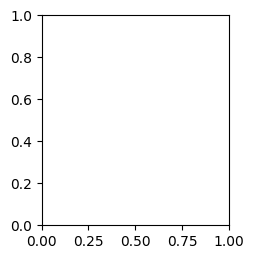

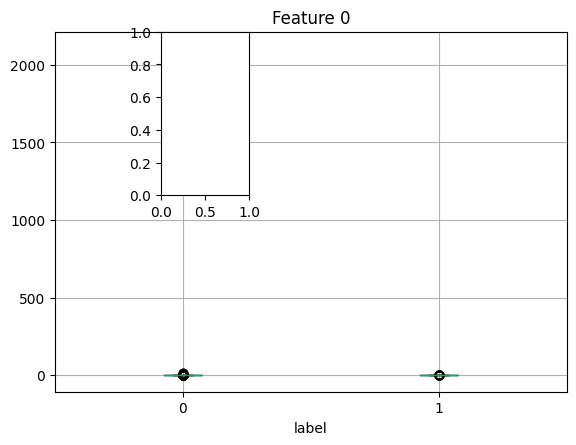

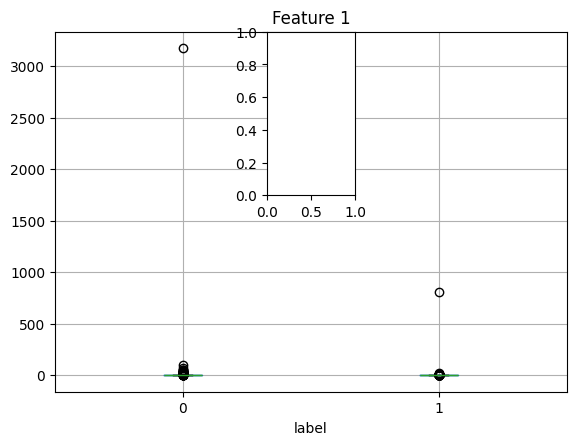

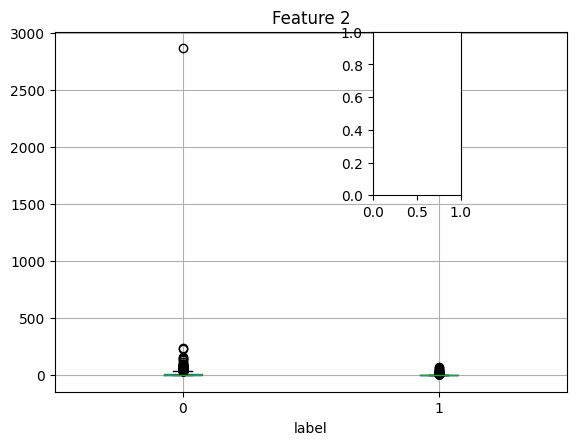

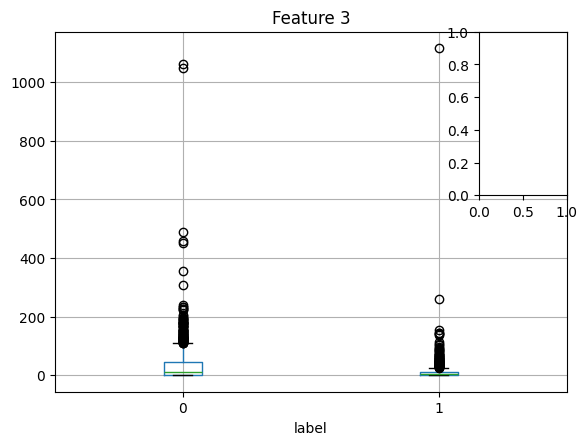

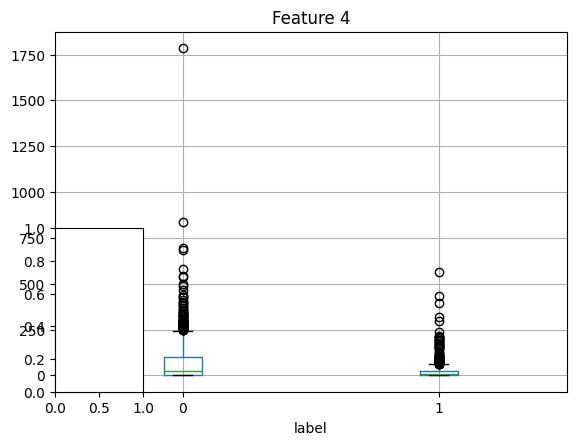

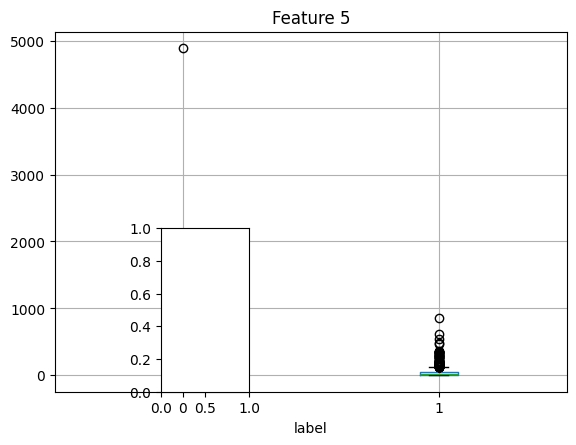

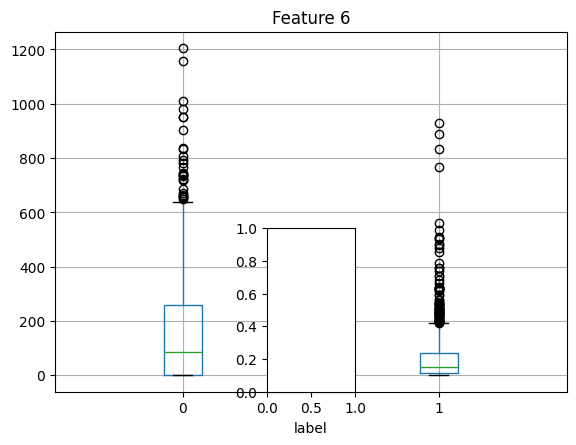

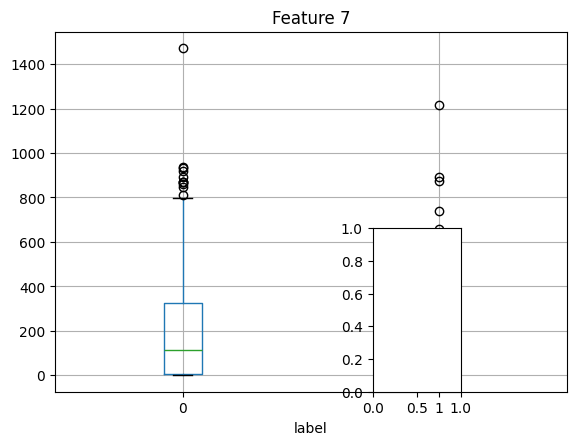

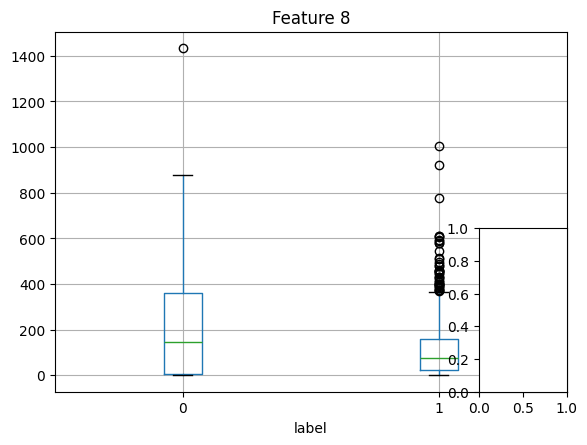

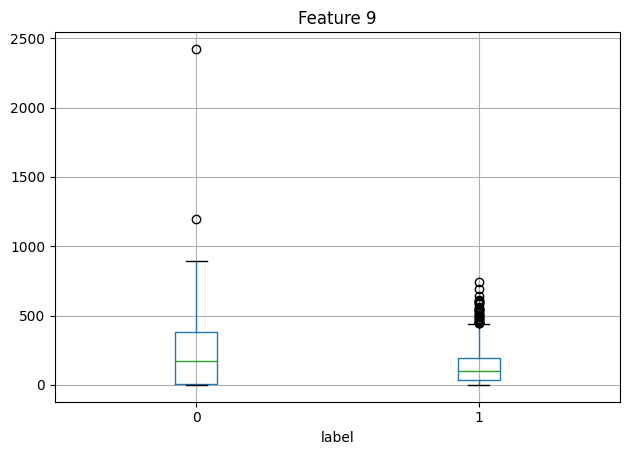

In [34]:
features_to_plot = 10

plt.figure(figsize=(14,6))
for i in range(features_to_plot):
    plt.subplot(2,5,i+1)
    X_df.boxplot(column=i, by='label')
    plt.title(f'Feature {i}')
    plt.suptitle("")
plt.tight_layout()
plt.show()


Correlation Heatmap (Feature Redundancy)

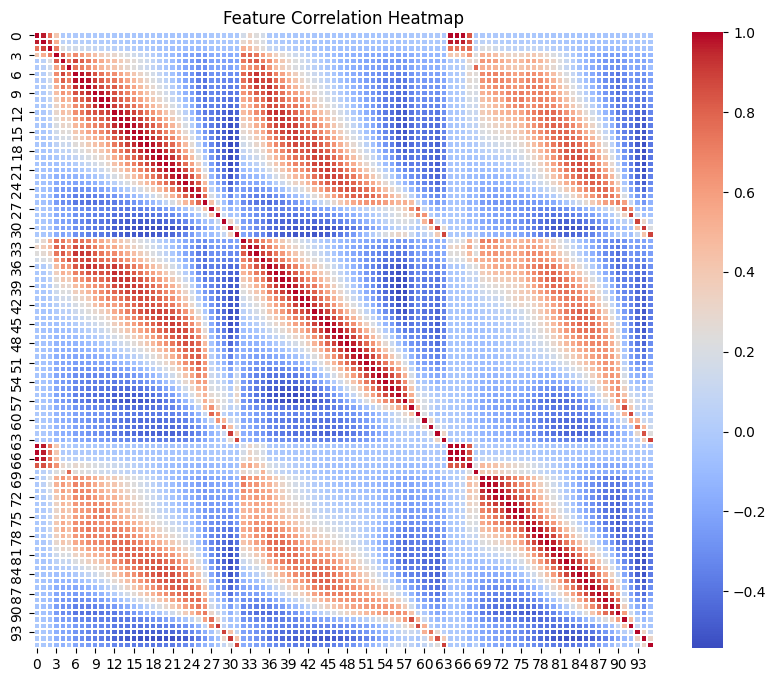

In [35]:
import seaborn as sns

corr_matrix = X_df.drop('label', axis=1).corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.1)
plt.title("Feature Correlation Heatmap")
plt.show()


Class Centroid Distance

In [36]:
from numpy.linalg import norm

centroid_0 = X_df[X_df['label']==0].drop('label', axis=1).mean().values
centroid_1 = X_df[X_df['label']==1].drop('label', axis=1).mean().values

distance = norm(centroid_0 - centroid_1)
print("Euclidean Distance between class centroids:", distance)


Euclidean Distance between class centroids: 1781.7296


Intra-class vs Inter-class Distance

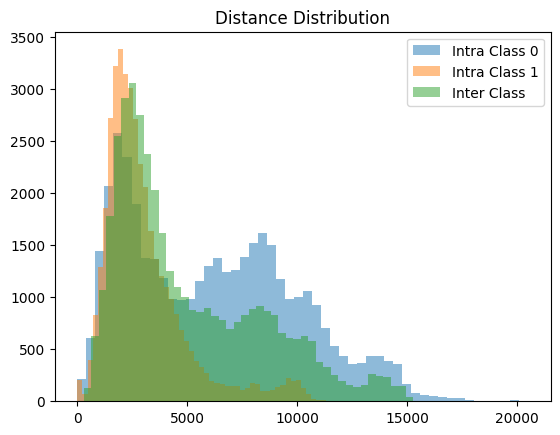

In [37]:
from sklearn.metrics import pairwise_distances

X0 = X_df[X_df['label']==0].drop('label', axis=1).values
X1 = X_df[X_df['label']==1].drop('label', axis=1).values

intra_0 = pairwise_distances(X0[:200], X0[:200]).flatten()
intra_1 = pairwise_distances(X1[:200], X1[:200]).flatten()
inter = pairwise_distances(X0[:200], X1[:200]).flatten()

plt.hist(intra_0, bins=50, alpha=0.5, label='Intra Class 0')
plt.hist(intra_1, bins=50, alpha=0.5, label='Intra Class 1')
plt.hist(inter, bins=50, alpha=0.5, label='Inter Class')
plt.legend()
plt.title("Distance Distribution")
plt.show()


## Outlier Detection & Handling

Z-score

In [38]:
features = np.array(features)
labels = np.array(labels)

features_df = pd.DataFrame(features)
features_df.columns = [f"feature_{i}" for i in range(features.shape[1])]
features_df["label"] = labels

features_df.head()



,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,label
0,0.0,0.0,2.0,4.0,11.0,23.0,30.0,32.0,50.0,52.0,...,522.0,550.0,601.0,655.0,676.0,703.0,754.0,583.0,795.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,...,545.0,341.0,280.0,216.0,208.0,210.0,165.0,123.0,227.0,0
2,0.0,0.0,0.0,0.0,0.0,3.0,6.0,7.0,15.0,48.0,...,703.0,704.0,725.0,738.0,727.0,658.0,583.0,490.0,1051.0,1
3,0.0,0.0,2.0,7.0,27.0,55.0,88.0,178.0,248.0,347.0,...,225.0,154.0,154.0,130.0,94.0,77.0,81.0,52.0,91.0,0
4,0.0,0.0,1.0,0.0,2.0,9.0,4.0,7.0,9.0,22.0,...,119.0,109.0,133.0,139.0,205.0,307.0,587.0,1596.0,5212.0,1


In [39]:
from scipy.stats import zscore

X_features = features_df.drop(columns=["label"])
z_scores = np.abs(zscore(X_features))

threshold = 3
outliers_mask = (z_scores > threshold).any(axis=1)

print("Number of outliers:", outliers_mask.sum())


Number of outliers: 557


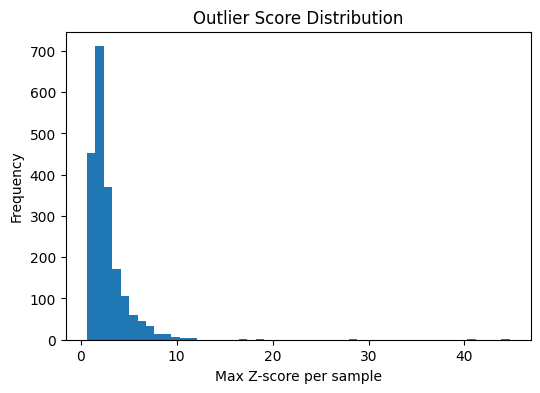

In [40]:
plt.figure(figsize=(6,4))
plt.hist(z_scores.max(axis=1), bins=50)
plt.title("Outlier Score Distribution")
plt.xlabel("Max Z-score per sample")
plt.ylabel("Frequency")
plt.show()

Outlier Removal


In [41]:
THRESHOLD = 10

In [42]:
z_scores = np.abs(zscore(X_features))


max_z = z_scores.max(axis=1)

# mask
mask = max_z < 10

X_clean = X_features[mask]
y_clean = labels[mask]

print("Before:", X_features.shape)
print("After :", X_clean.shape)


Before: (2000, 96)
After : (1985, 96)


## Feature Redundancy Removal

In [ ]:
X_clean_df = pd.DataFrame(
    X_clean,
    columns=[f"f_{i}" for i in range(X_clean.shape[1])]
)

# Correlation
corr_matrix = X_clean_df.corr().abs()

threshold = 0.9

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [
    column for column in upper.columns
    if any(upper[column] > threshold)
]

X_reduced = X_clean_df.drop(columns=to_drop)

print("Original features:", X_clean_df.shape[1])
print("After redundancy removal:", X_reduced.shape[1])


Original features: 96
After redundancy removal: 96


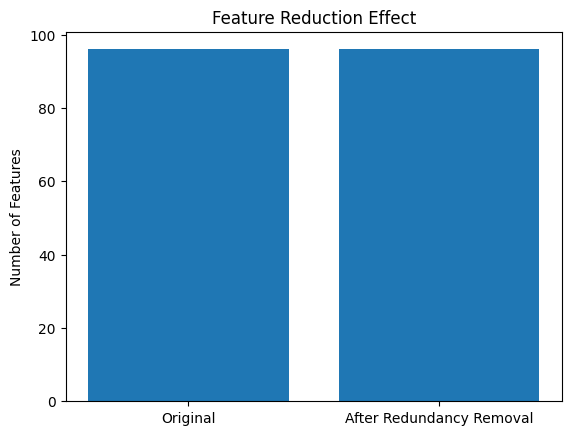

In [45]:
plt.bar(
    ["Original", "After Redundancy Removal"],
    [X_clean.shape[1], X_reduced.shape[1]]
)
plt.title("Feature Reduction Effect")
plt.ylabel("Number of Features")
plt.show()


## PCA – Dimensionality Reduction Effect of Feature Selection

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1️⃣ Imputation
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X_features)

print("Shape after imputation:", X_imputed.shape)
print("NaNs:", np.isnan(X_imputed).sum())

# 2️⃣ Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 3️⃣ PCA
pca = PCA(n_components=20)   
X_pca = pca.fit_transform(X_scaled)

print("Final PCA shape:", X_pca.shape)


Shape after imputation: (2000, 96)
NaNs: 0
Final PCA shape: (2000, 20)


Explained Variance (Final PCA)

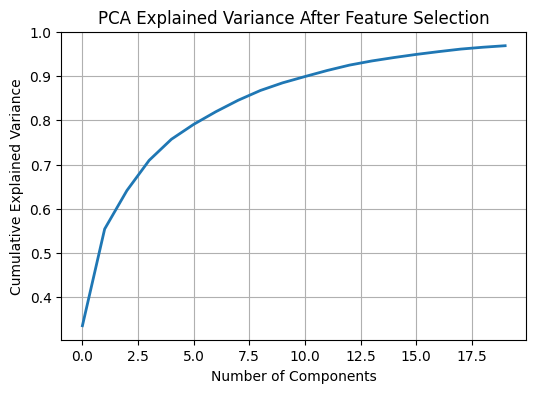

In [49]:
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance After Feature Selection")
plt.grid()
plt.show()


PCA 2D Scatter (Final Representation)

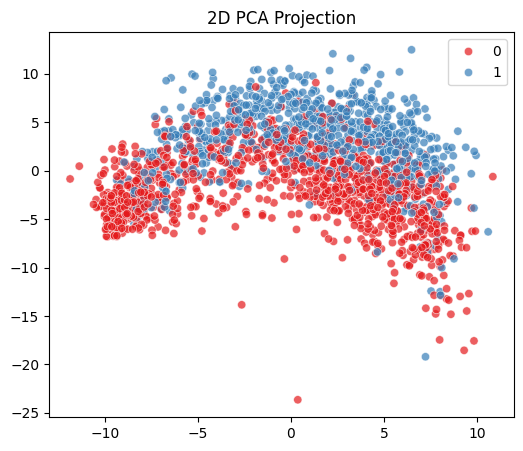

In [52]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=y,
    palette="Set1",
    alpha=0.7
)
plt.title("2D PCA Projection")
plt.show()


## Dataset Summary

Summary Numbers

In [53]:
print("Dataset Summary")
print("-" * 40)

print(f"Number of samples: {X_clean.shape[0]}")
print(f"Number of features: {X_clean.shape[1]}")

print("\nClass distribution:")
print(pd.Series(y_clean).value_counts())

print("\nClass percentages:")
print(pd.Series(y_clean).value_counts(normalize=True) * 100)


Dataset Summary
----------------------------------------
Number of samples: 1985
Number of features: 96

Class distribution:
0    1147
1     838
dtype: int64

Class percentages:
0    57.783375
1    42.216625
dtype: float64


Descriptive Statistics (Features)

In [54]:
summary_df = pd.DataFrame(X_clean)
summary_df.describe()


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95
count,1985.000000,1985.000000,1985.000000,1985.000000,1985.000000,1985.000000,1985.000000,1985.000000,1985.000000,1985.000000,...,1985.000000,1985.000000,1985.000000,1985.000000,1985.000000,1985.000000,1985.000000,1985.000000,1985.000000,1985.000000
mean,0.247859,1.883627,7.722922,21.884130,47.795467,82.387405,117.888664,146.950623,168.400497,182.466995,...,451.681122,451.252899,441.268005,421.903290,407.211578,448.140564,605.227234,577.981873,699.641296,560.555176
std,0.946144,4.542259,15.515594,39.243572,79.426979,124.301674,160.573120,180.025314,185.801971,183.048996,...,251.087845,251.489151,246.431717,241.320374,239.374023,410.390320,1040.253052,936.682556,1268.896118,729.945862
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,6.000000,10.000000,16.000000,22.000000,...,264.000000,259.000000,254.000000,244.000000,236.000000,221.000000,205.000000,175.000000,129.000000,189.000000
50%,0.000000,0.000000,1.000000,5.000000,12.000000,26.000000,47.000000,70.000000,95.000000,123.000000,...,433.000000,434.000000,411.000000,387.000000,367.000000,352.000000,331.000000,293.000000,228.000000,372.000000
75%,0.000000,2.000000,8.000000,26.000000,59.000000,110.000000,172.000000,232.000000,279.000000,302.000000,...,614.000000,612.000000,597.000000,561.000000,539.000000,554.000000,566.000000,556.000000,494.000000,650.000000
max,16.000000,70.000000,227.000000,458.000000,697.000000,912.000000,980.000000,939.000000,922.000000,891.000000,...,1607.000000,1608.000000,1524.000000,1838.000000,2160.000000,4571.000000,9164.000000,9062.000000,8932.000000,7296.000000


Check Missing / Invalid Values

In [55]:
print("Missing values per feature:")
print(summary_df.isnull().sum().sum())


Missing values per feature:
0


Feature Variance Overview

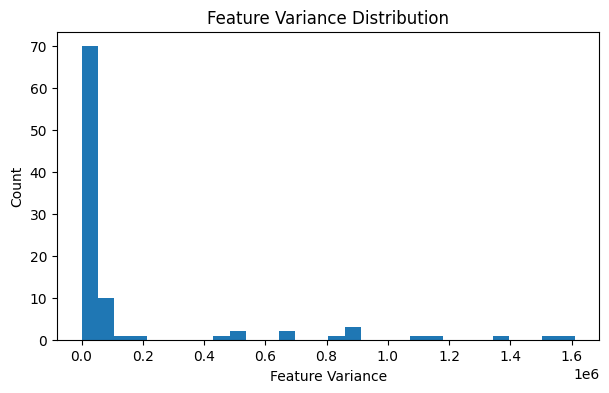

In [56]:
feature_variance = summary_df.var()

plt.figure(figsize=(7,4))
plt.hist(feature_variance, bins=30)
plt.xlabel("Feature Variance")
plt.ylabel("Count")
plt.title("Feature Variance Distribution")
plt.show()


Final Dataset Shape (Ready for Modeling)

In [57]:
print("Final dataset shape (ready for modeling):")
print("X:", X_clean.shape)
print("y:", y_clean.shape)


Final dataset shape (ready for modeling):
X: (1985, 96)
y: (1985,)


## Preprocessing Pipeline Summary

In [58]:
pipeline_summary = pd.DataFrame({
    "Step": [
        "Data Loading",
        "Data Cleaning",
        "Noise & Outlier Detection",
        "Normalization",
        "Image Resizing",
        "Feature Extraction",
        "Feature Selection",
        "Dimensionality Reduction (PCA)"
    ],
    "Description": [
        "Load images and labels",
        "Remove corrupted images and missing labels",
        "Detect and remove extreme outliers using Z-score",
        "Scale pixel values to [0,1]",
        "Resize images to fixed dimensions",
        "Extract hand-crafted features (color, texture, edges)",
        "Remove low-variance features",
        "Reduce dimensionality while preserving variance"
    ]
})

pipeline_summary


,Step,Description
0,Data Loading,Load images and labels
1,Data Cleaning,Remove corrupted images and missing labels
2,Noise & Outlier Detection,Detect and remove extreme outliers using Z-score
3,Normalization,"Scale pixel values to [0,1]"
4,Image Resizing,Resize images to fixed dimensions
5,Feature Extraction,"Extract hand-crafted features (color, texture,..."
6,Feature Selection,Remove low-variance features
7,Dimensionality Reduction (PCA),Reduce dimensionality while preserving variance


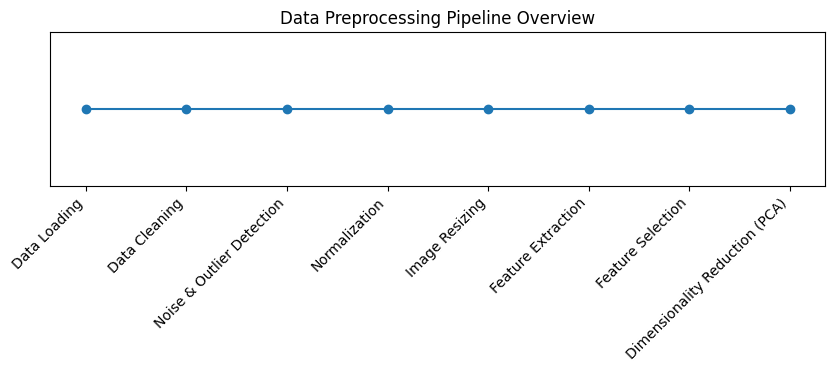

In [59]:
steps = pipeline_summary["Step"]

plt.figure(figsize=(10,2))
plt.plot(range(len(steps)), [1]*len(steps), "o-")
plt.yticks([])
plt.xticks(range(len(steps)), steps, rotation=45, ha="right")
plt.title("Data Preprocessing Pipeline Overview")
plt.show()


In [29]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [30]:
DATA_DIR = r"D:\histopathologic-cancer-detection-"
TRAIN_DIR = os.path.join(DATA_DIR, "train")

df = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))

print(df.head())
print("\nLabel distribution:")
print(df['label'].value_counts())


                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Label distribution:
0    130908
1     89117
Name: label, dtype: int64


In [31]:
IMG_SIZE = 224

def load_image(img_id):
    path = os.path.join(TRAIN_DIR, img_id + ".tif")
    img = cv2.imread(path)

    if img is None:
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img


In [32]:
SAMPLE_SIZE = 8000  

df_sample, _ = train_test_split(
    df,
    train_size=SAMPLE_SIZE,
    stratify=df['label'],
    random_state=42
)

print("\nSample label distribution:")
print(df_sample['label'].value_counts())



Sample label distribution:
0    4760
1    3240
Name: label, dtype: int64


In [33]:
images = []
labels = []

for img_id, label in zip(df_sample['id'], df_sample['label']):
    img = load_image(img_id)
    if img is not None:
        images.append(img)
        labels.append(label)

X_images = np.array(images)
y = np.array(labels)

X_images = preprocess_input(X_images)

print("Images shape:", X_images.shape)
print("Labels shape:", y.shape)


Images shape: (8000, 224, 224, 3)
Labels shape: (8000,)


In [35]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=(224,224,3)
)

base_model.trainable = False


In [36]:
X_features = base_model.predict(
    X_images,
    batch_size=32,
    verbose=1
)

print("Deep feature shape:", X_features.shape)
# (N_samples, 1280)


250/250 [==============================] - 145s 560ms/step
Deep feature shape: (8000, 1280)


In [37]:
X_train, X_val, y_train, y_val = train_test_split(
    X_features,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("\nTrain distribution:")
print(pd.Series(y_train).value_counts())

print("\nValidation distribution:")
print(pd.Series(y_val).value_counts())



Train distribution:
0    3808
1    2592
dtype: int64

Validation distribution:
0    952
1    648
dtype: int64


In [38]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)


In [39]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: 0.8403361344537815, 1: 1.2345679012345678}


In [42]:
import tensorflow as tf

def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        # p_t
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)

        # alpha factor
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)

        # focal loss
        loss = -alpha_factor * tf.pow((1 - p_t), gamma) * tf.math.log(p_t)
        return tf.reduce_mean(loss)

    return focal_loss


In [43]:
model = Sequential([
    Dense(256, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.5),

    Dense(128, activation="relu"),
    Dropout(0.3),

    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=binary_focal_loss(gamma=2.0, alpha=0.25),
    metrics=["accuracy"]
)


model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               327936    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 360961 (1.38 MB)
Trainable params: 360961 (1.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=6,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/40
200/200 [==============================] - 4s 7ms/step - loss: 0.1240 - accuracy: 0.6972 - val_loss: 0.0487 - val_accuracy: 0.7931
Epoch 2/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0775 - accuracy: 0.7641 - val_loss: 0.0428 - val_accuracy: 0.8100
Epoch 3/40
200/200 [==============================] - 1s 5ms/step - loss: 0.0669 - accuracy: 0.7798 - val_loss: 0.0400 - val_accuracy: 0.8213
Epoch 4/40
200/200 [==============================] - 1s 5ms/step - loss: 0.0580 - accuracy: 0.7950 - val_loss: 0.0375 - val_accuracy: 0.8225
Epoch 5/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0513 - accuracy: 0.8087 - val_loss: 0.0355 - val_accuracy: 0.8350
Epoch 6/40
200/200 [==============================] - 1s 6ms/step - loss: 0.0480 - accuracy: 0.8128 - val_loss: 0.0356 - val_accuracy: 0.8325
Epoch 7/40
200/200 [==============================] - 1s 7ms/step - loss: 0.0466 - accuracy: 0.8216 - val_loss: 0.0348 - val_accuracy: 0.8350
Epoch 

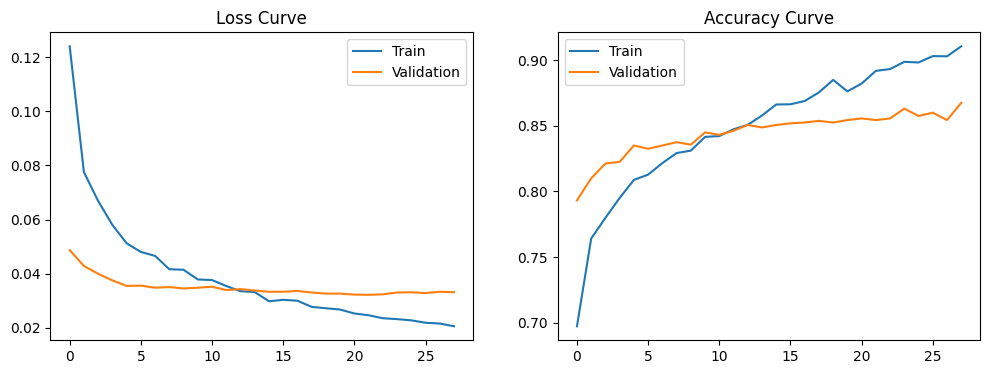

In [45]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Validation")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


In [46]:
y_probs = model.predict(X_val).ravel()

THRESHOLD = 0.4   
y_pred = (y_probs > THRESHOLD).astype(int)


print("Final Classification Report:\n")
print(classification_report(y_val, y_pred))


50/50 [==============================] - 0s 2ms/step
Final Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       952
           1       0.86      0.82      0.84       648

    accuracy                           0.87      1600
   macro avg       0.87      0.87      0.87      1600
weighted avg       0.87      0.87      0.87      1600



In [48]:
print("Final Train Accuracy:",
      history.history['accuracy'][-1])

print("Final Validation Accuracy:",
      history.history['val_accuracy'][-1])


Final Train Accuracy: 0.9106249809265137
Final Validation Accuracy: 0.8675000071525574


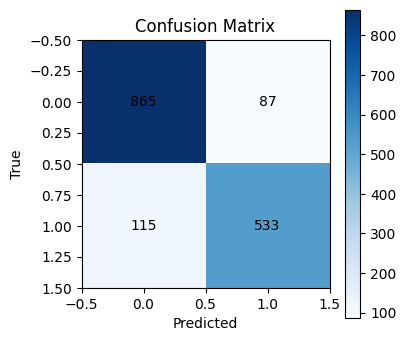

In [49]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center", color="black")

plt.show()


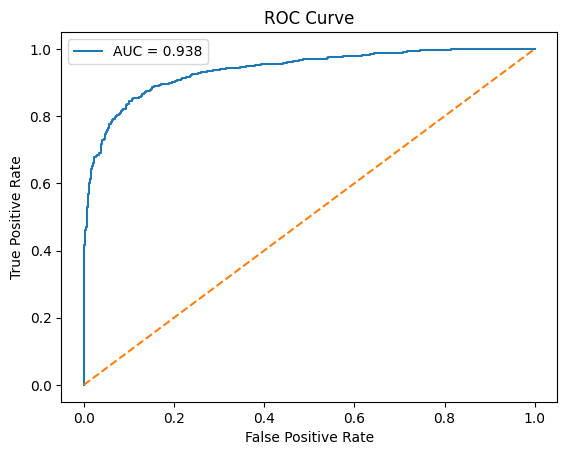

In [50]:
fpr, tpr, _ = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
